# Tutorial 05: Collision Checks With Dynamic Obstacles

This tutorial shows you how to use the drivability checker library in order to quickly check if multiple ego-vehicle trajectories collide
with a set of dynamic obstacles. The future motions of the dynamic obstacles can either be described by their predicted trajectories
(*trajectory prediction*) or their drivable areas (*set-based prediction*).


## 1. Necessary imports and helper functions
We begin by importing all necessary modules and setting up helper functions.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

# commonroad
from commonroad.prediction.prediction import TrajectoryPrediction, SetBasedPrediction
from commonroad.visualization.mp_renderer import MPRenderer

#commonroad-io
from commonroad.common.file_reader import CommonRoadFileReader

# commonroad_dc
import commonroad_dc.pycrcc as pycrcc
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker, create_collision_object
from commonroad_dc.boundary import boundary
from commonroad_dc.collision.trajectory_queries import trajectory_queries
from commonroad_dc.pycrcc.Util import trajectory_enclosure_polygons_static


def open_scenario(scenario_filename):

    crfr = CommonRoadFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set


directory = './'

## 2. Collision checks
We demonstrate the collision checking for two CommonRoad scenarios:
* **USA_US101-3_3_T-1** contains the predicted trajectories of all dynamic obstacles
* **USA_US101-3_3_S-1** uses set-based prediction and contains the predicted drivable areas

We open and visualize the first scenario (trajectory prediction).

 Text(1.0, 0.0, ''),

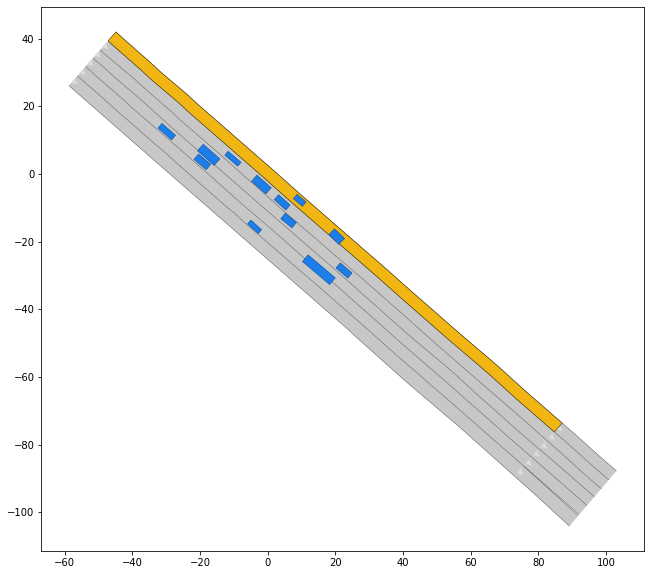

In [2]:
# scenario names for both considered scenarios
scenario_name_trajectory_prediction="USA_US101-3_3_T-1"
scenario_name_set_prediction="USA_US101-3_3_S-1"

# open the example scenario with trajectory predictions
scenario, planning_problem_set = open_scenario(directory+scenario_name_trajectory_prediction+'.xml')

# plot the scenario
rnd = MPRenderer(figsize=(25, 10))
scenario.draw(rnd)
planning_problem_set.draw(rnd)
rnd.render()

For this tutorial we have stored the waypoints for a set of 1000 trajectories in a file (*USA_US101-3_3_T-1_waypoints.npz*).
The function `get_trajectory_list()` returns the trajectory batch as a list, where each trajectory is represented as a Time-Variant Collision Object.

In [5]:
def get_trajectory_list(loaded, obb_hull_preprocess=True):
    traj_matrix=loaded["trajectories"].reshape(1000,-1)
    start_time=np.asfortranarray(loaded["start_time_step"].astype(int))
    half_car_length, half_car_width=loaded["car_shape"]/2

    # create a trajectory batch
    trajectories_batch=pycrcc.OBBTrajectoryBatch(traj_matrix,start_time, half_car_length, half_car_width)
    # preprocess the trajectory batch for continuous collision detection using OBB Hull method (see also Tutorial 03)
    if obb_hull_preprocess:
        trajectories_batch.preprocess_()

    return trajectories_batch.to_tvobstacle()


We load the data from the `*.npz` file and generate the trajectory batch as a list.

In [6]:
data=np.load(scenario_name_trajectory_prediction+"_waypoints.npz")
loaded_data = {"car_shape": data["car_shape"], "trajectories": data["trajectories"], "start_time_step": data["start_time_step"]}
data.close()

trajectories = get_trajectory_list(loaded_data)
waypoints=loaded_data["trajectories"]
car_shape=loaded_data["car_shape"]
car_half_length, car_half_width = (car_shape/2)


After loading the trajectory batch, we create the road boundary (see *Tutorial 03: road compliance checking* for details).
The scenario and an exemplary part of the trajectory batch is visualized below.

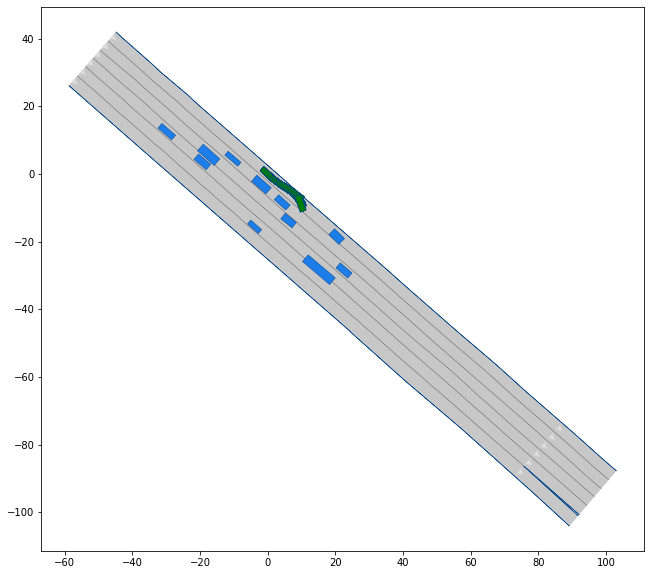

In [7]:
# create the road boundary with default method uses oriented rectangles
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario)
road_polygons = boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)

# Draw an exemplary part of trajectory batch (here: 50 trajectories) and the road boundary
n_traj_draw=50
offset=350

rnd = MPRenderer(figsize=(25, 10))
scenario.draw(rnd)
road_boundary_sg_rectangles.draw(rnd)
for tvo in trajectories[offset:offset+n_traj_draw]:
    rnd.draw_params.shape.facecolor = "green"
    tvo.draw(rnd)
rnd.render()

## 2.1. Check if trajectory is within the road (static collision checking)
We can check the trajectory batch for road-compliance by performing a static collision check with the road boundary, as
demonstrated in *Tutorial 03: road compliance checking*.

#### Simplified approach (check for the collision of each trajectory with the road boundary)

In [6]:
# check computation time over ten runs
num_trials=10

cur_time_1=time()
for i in range(num_trials):
    # check if the trajectory collides with the road boundary
    ret=trajectory_queries.trajectories_collision_static_obstacles(trajectories, road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True, optimize_triangles=True)
cur_time_2 = time()

print("%s out of %s checked trajectories do not collide with the road boundary." % (ret.count(-1), len(trajectories)))
print("Time for %s trajectory checks: " % (len(trajectories)) + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

620 out of 1000 checked trajectories do not collide with the road boundary.
Time for 1000 trajectory checks: 0.012477779388427734 sec.


#### Full approach (check if the vehicle is within the road at the first time step, then check if the trajectory collides with the road boundary)

In [7]:
# check computation time over ten runs
num_trials=10

cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    
    #select only the trajectories for which the vehicle is within the road at the first timestep
    candidate_trajectories=trajectory_queries.filter_trajectories_polygon_enclosure_first_timestep(trajectories,road_polygons)  
            
    # check if the trajectory collides with the road boundary
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True, optimize_triangles=True)
cur_time_2 = time()

print("%s out of %s checked trajectories are fully within the road." % (ret.count(-1), len(trajectories)))
print("Time for %s trajectory checks: " % (len(trajectories)) + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


620 out of 1000 checked trajectories are fully within the road.
Time for 1000 trajectory checks: 0.03284108638763428 sec.


## 2.2. Dynamic collision checking
Afterwards, we can check whether the trajectories collide with the dynamic obstacles in the scenario using either *trajectory predictions* (Section 2.2.1.)
or *set-based predictions* (Section 2.2.2)

### 2.2.1. Trajectory predictions

The function `get_scenario_dynamic_obstacles_list()` returns the dynamic obstacles in the scenario as a list of Time-Variant
Collision Objects. We preprocess the trajectories of other vehicles for continuous collision checking using `trajectory_preprocess_obb_sum()`,
which creates a conves hull around the occupancies of two subsequent time steps.

In [8]:
def get_scenario_dynamic_obstacles_list(scenario):
    dyn_obstacles_list=list()
    for dyn_obst in scenario.dynamic_obstacles:
        if isinstance(dyn_obst.prediction,TrajectoryPrediction):
            co=create_collision_object(dyn_obst.prediction)
            # preprocess using obb hull for continuous collision detection
            co, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
            dyn_obstacles_list.append(co)
        else:
            if isinstance(dyn_obst.prediction,SetBasedPrediction):
                co=create_collision_object(dyn_obst.prediction)
                dyn_obstacles_list.append(co)    
            else:
                raise Exception('Unknown dynamic obstacle prediction type: ' + str(type(dyn_obst.prediction))) 
    return dyn_obstacles_list

We get all dynamic obstacles in the scenario with the trajectory prediction:

In [9]:
dynamic_obstacles=get_scenario_dynamic_obstacles_list(scenario)

Then, we can check the trajectory batch for collision with other dynamic obstacles.

In [10]:
# check computation time over ten runs
num_trials=10

cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, dynamic_obstacles, method='box2d')
cur_time_2 = time()

print("%s out of %s trajectories do not collide with the other vehicles" % (res_dynamic.count(-1), len(trajectories)))
print("Time for %s trajectory checks: " % (len(trajectories)) + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

820 out of 1000 trajectories do not collide with the other vehicles
Time for 1000 trajectory checks: 0.009562110900878907 sec.


### 2.2.2. Set-based predictions

We open the second scenario which uses set-based predictions for the dynamic obstacles.

In [11]:
# open the example scenario with set-based predictions
scenario, planning_problem_set = open_scenario(directory+scenario_name_set_prediction+'.xml')

/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step Interval
start: 10
end: 10
 cannot be matched!
  warnings.warn("State at time step {} cannot be matched!".format(read_time(xml_node.find('time'))))


Again we create the road boundary and visualize the scenario.

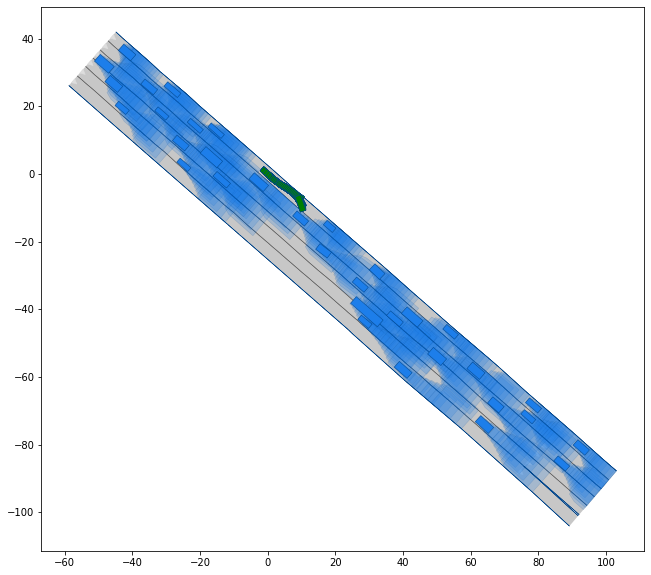

In [12]:
# create road boundary with default method using oriented rectangles
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario)
road_polygons = boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)
    
# Draw an exemplary part of trajectory batch (here: 50 trajectories) and the road boundary
n_traj_draw=50
offset=350

rnd = MPRenderer(figsize=(25, 10))
scenario.draw(rnd)
road_boundary_sg_rectangles.draw(rnd)
for tvo in trajectories[offset:offset+n_traj_draw]:
    rnd.draw_params.shape.facecolor = "green"
    tvo.draw(rnd)
rnd.render()

We retrieve all dynamic obstacles in the scenario.

In [13]:
dynamic_obstacles=get_scenario_dynamic_obstacles_list(scenario)

Finally, we can check the trajectory batch for collision with the set-based predictions of the other traffic participants.


In [14]:
# check computation time over ten runs
num_trials=10

cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, dynamic_obstacles, method='grid')
cur_time_2 = time()

print("%s out of %s trajectories do not collide with the set-based predictions" % (res_dynamic.count(-1), len(trajectories)))
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")



1000 out of 1000 trajectories do not collide with the set-based predictions
Time for 1000 trajectory checks: 0.016235756874084472 sec.
